In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
chunks = {"time": 24}

original = xr.open_dataset("/g/data/xv83/users/bxn599/wbgt/CESM2_ssp370/wbgt_AUS-10i_CESM2_ssp370_r11i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_1hr_201501010000-201512312300.nc", chunks=chunks)
lon_shif = xr.open_dataset("/scratch/e53/bxn599/aus10i/CESM2_ssp370/wbgt_AUS-10i_CESM2_ssp370_r11i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_1hr_201501010000-201512312300.nc", chunks=chunks)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [3]:
wbgt_original = original['wbgt']
wbgt_lon_shif = lon_shif['wbgt']

wbgt_original = wbgt_original.assign_coords(lon=wbgt_original.lon.round(2))
wbgt_original = wbgt_original.assign_coords(lat=wbgt_original.lat.round(2))
wbgt_lon_shif = wbgt_lon_shif.assign_coords(lon=wbgt_original.lon.round(2))
wbgt_lon_shif = wbgt_lon_shif.assign_coords(lat=wbgt_original.lat.round(2))

In [4]:
print(wbgt_original)
print(wbgt_lon_shif)

<xarray.DataArray 'wbgt' (time: 8760, lat: 612, lon: 929)> Size: 20GB
dask.array<open_dataset-wbgt, shape=(8760, 612, 929), dtype=float32, chunksize=(24, 612, 929), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 70kB 2015-01-01 00:00:00 ... 2015-12-31 23:00:00
  * lat      (lat) float64 5kB -52.4 -52.3 -52.2 -52.1 -52.0 ... 8.4 8.5 8.6 8.7
  * lon      (lon) float64 7kB 89.2 89.3 89.4 89.5 ... 181.7 181.8 181.9 182.0
Attributes:
    long_name:  Wet Bulb Globe Temperature
    units:      degK
<xarray.DataArray 'wbgt' (time: 8760, lat: 612, lon: 929)> Size: 20GB
dask.array<open_dataset-wbgt, shape=(8760, 612, 929), dtype=float32, chunksize=(24, 612, 929), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 70kB 2015-01-01 00:00:00 ... 2015-12-31 23:00:00
  * lat      (lat) float64 5kB -52.4 -52.3 -52.2 -52.1 -52.0 ... 8.4 8.5 8.6 8.7
  * lon      (lon) float64 7kB 89.2 89.3 89.4 89.5 ... 181.7 181.8 181.9 182.0
Attributes:
    long_name:  Wet Bulb Globe Tem

In [5]:
diff_lon_shif = wbgt_lon_shif - wbgt_original

In [6]:
da = diff_lon_shif

# 1. max over space for each time step
spatial_max = da.max(dim=("lat", "lon"))

# 2. time index where global max occurs
itime = spatial_max.argmax().compute().item()

# 3. extract that time slice and find lat/lon index
slice2d = da.isel(time=itime)

flat_index = slice2d.argmax().compute().item()
nlon = da.sizes["lon"]

ilat = flat_index // nlon
ilon = flat_index %  nlon

# 4. coordinate values
max_val = spatial_max[itime].compute().item()
max_time = da.time.values[itime]
max_lat  = da.lat.values[ilat]
max_lon  = da.lon.values[ilon]

# 1. max over space for each time step
spatial_min = da.min(dim=("lat", "lon"))

# 2. time index where global max occurs
itime = spatial_min.argmin().compute().item()

# 3. extract that time slice and find lat/lon index
slice2d = da.isel(time=itime)

flat_index = slice2d.argmin().compute().item()
nlon = da.sizes["lon"]

ilat = flat_index // nlon
ilon = flat_index %  nlon

# 4. coordinate values
min_val = spatial_min[itime].compute().item()
min_time = da.time.values[itime]
min_lat  = da.lat.values[ilat]
min_lon  = da.lon.values[ilon]

print("MIN VALUE:", min_val)
print("TIME:", min_time)
print("LAT:", min_lat)
print("LON:", min_lon)

print("MAX VALUE:", max_val)
print("TIME:", max_time)
print("LAT:", max_lat)
print("LON:", max_lon)

MIN VALUE: 0.0
TIME: 2015-01-01 00:00:00
LAT: -52.4
LON: 89.2
MAX VALUE: 0.0
TIME: 2015-01-01 00:00:00
LAT: -52.4
LON: 89.2


## WBGT at 127.5E, 0.0 
Lon shifted 0.00001 only for 127.5E, 0.0

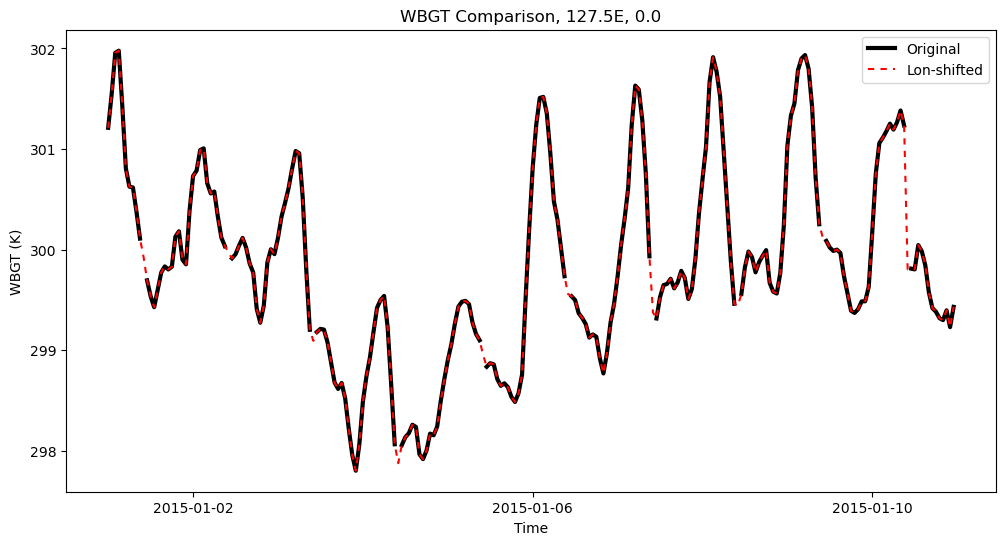

In [7]:
# Create figure and axis
plt.figure(figsize=(12, 6))

# Plot original
wbgt_original[0:240].sel(lon=127.5, lat=0.0).plot(
    label='Original',
    color="black",
    linewidth=3
)

# Plot lon-shifted on same axis
wbgt_lon_shif[0:240].sel(lon=127.5, lat=0.0).plot(
    dashes=[3, 3],
    label='Lon-shifted',
    color="red"
)

# Add legend
plt.legend()

# Add title and labels
plt.title('WBGT Comparison, 127.5E, 0.0')
plt.xlabel('Time')
plt.ylabel('WBGT (K)')

plt.show()